In [1]:
import torch
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Make torch deterministic
torch.manual_seed(0)

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Exclude all instances corresponding to the digit 9
exclude_indices = mnist_trainset.targets == 9
mnist_trainset.data = mnist_trainset.data[~exclude_indices]
mnist_trainset.targets = mnist_trainset.targets[~exclude_indices]

# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Load the MNIST test set (don't exclude any digits)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=True)

In [4]:
# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create an overly expensive neural network to classify MNIST digits
# Daddy got money, so I don't care about efficiency
class RichBoyNet(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000):
        super(RichBoyNet,self).__init__()
        self.linear1 = nn.Linear(28*28, hidden_size_1) 
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2) 
        self.linear3 = nn.Linear(hidden_size_2, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

net = RichBoyNet().to(device)

In [5]:
def train(train_loader, net, epochs=5):
    cross_el = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    for epoch in range(epochs):
        net.train()

        loss_sum = 0
        num_iterations = 0

        data_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        for data in data_iterator:
            num_iterations += 1
            x, y = data
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = net(x.view(-1, 28*28))
            loss = cross_el(output, y)
            loss_sum += loss.item()
            avg_loss = loss_sum / num_iterations
            data_iterator.set_postfix(loss=avg_loss)
            loss.backward()
            optimizer.step()

train(train_loader, net, epochs=10)

original_weights = {}
for name, param in net.named_parameters():
    original_weights[name] = param.clone().detach()


Epoch 10: 100%|██████████| 5406/5406 [00:19<00:00, 271.20it/s, loss=0.0483]


In [6]:
def test():
    correct = 0
    total = 0

    wrong_counts = [0 for i in range(10)]

    with torch.no_grad():
        for data in tqdm(test_loader, desc='Testing'):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            output = net(x.view(-1, 784))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct +=1
                else:
                    wrong_counts[y[idx]] +=1
                total +=1
    print(f'Accuracy: {round(correct/total, 3)}')
    for i in range(len(wrong_counts)):
        print(f'wrong counts for {i}: {wrong_counts[i]}')

test()

Testing: 100%|██████████| 1000/1000 [00:02<00:00, 391.84it/s]

Accuracy: 0.883
wrong counts for 0: 8
wrong counts for 1: 7
wrong counts for 2: 30
wrong counts for 3: 17
wrong counts for 4: 18
wrong counts for 5: 25
wrong counts for 6: 17
wrong counts for 7: 17
wrong counts for 8: 23
wrong counts for 9: 1009


In [7]:
# Print the size of the weights matrices of the network
for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    print(
        f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}'
    )

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10])


In [8]:
import math

class LoRAParametrization(nn.Module):
    def __init__(self, features_in, features_out, rank=4, lora_alpha=1, device='cpu'):
        super().__init__()
        self.lora_A = nn.Parameter(torch.zeros((rank,features_out)).to(device))
        self.lora_B = nn.Parameter(torch.zeros((features_in, rank)).to(device))
        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        self.lora_alpha, self.rank = lora_alpha, rank
        self.scale = lora_alpha / rank
        self.enabled = True

    def forward(self, X):
        if self.enabled:
            # Return X + (B*A)*scale
            return X + torch.matmul(self.lora_B, self.lora_A).view(X.shape) * self.scale
        else:
            return X

In [9]:
import torch.nn.utils.parametrize as parametrize


def linear_layer_parameterization(layer, device, rank=4, lora_alpha=1):
    features_in, features_out = layer.weight.shape
    return LoRAParametrization(
        features_in, features_out, rank=rank, lora_alpha=lora_alpha, device=device
    )


parametrize.register_parametrization(
    net.linear1, "weight", linear_layer_parameterization(net.linear1, device)
)
parametrize.register_parametrization(
    net.linear2, "weight", linear_layer_parameterization(net.linear2, device)
)
parametrize.register_parametrization(
    net.linear3, "weight", linear_layer_parameterization(net.linear3, device)
)


def enable_disable_lora(enabled=True):
    for layer in [net.linear1, net.linear2, net.linear3]:
        layer.parametrizations["weight"][0].enabled = enabled

for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    print(
        f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape} + Lora_A: {layer.parametrizations["weight"][0].lora_A.shape} + Lora_B: {layer.parametrizations["weight"][0].lora_B.shape}'
    )

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000]) + Lora_A: torch.Size([4, 784]) + Lora_B: torch.Size([1000, 4])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000]) + Lora_A: torch.Size([4, 1000]) + Lora_B: torch.Size([2000, 4])
Layer 3: W: torch.Size([10, 2000]) + B: torch.Size([10]) + Lora_A: torch.Size([4, 2000]) + Lora_B: torch.Size([10, 4])


In [10]:
# Freeze the non-Lora parameters
for name, param in net.named_parameters():
    if 'lora' not in name:
        print(f'Freezing {name}')
        param.requires_grad = False

# Load the MNIST dataset again, by keeping only the digit 9
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_trainset.data = mnist_trainset.data[exclude_indices]
mnist_trainset.targets = mnist_trainset.targets[exclude_indices]
# Create a dataloader for the training
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True)

# Train the network with LoRA
train(train_loader, net, epochs=1)

Freezing linear1.bias
Freezing linear1.parametrizations.weight.original
Freezing linear2.bias
Freezing linear2.parametrizations.weight.original
Freezing linear3.bias
Freezing linear3.parametrizations.weight.original


Epoch 1:   0%|          | 0/595 [00:00<?, ?it/s, loss=63.9]

Epoch 1: 100%|██████████| 595/595 [00:02<00:00, 253.48it/s, loss=9.34]


In [19]:
# Check that the frozen parameters are still unchanged by the finetuning
assert torch.all(net.linear1.parametrizations.weight.original == original_weights['linear1.weight'])
assert torch.all(net.linear2.parametrizations.weight.original == original_weights['linear2.weight'])
assert torch.all(net.linear3.parametrizations.weight.original == original_weights['linear3.weight'])

In [21]:
# Test with LoRA enabled
enable_disable_lora(enabled=True)
test()

Testing: 100%|██████████| 1000/1000 [00:03<00:00, 316.56it/s]

Accuracy: 0.617
wrong counts for 0: 185
wrong counts for 1: 194
wrong counts for 2: 281
wrong counts for 3: 247
wrong counts for 4: 759
wrong counts for 5: 409
wrong counts for 6: 54
wrong counts for 7: 775
wrong counts for 8: 927
wrong counts for 9: 1


In [22]:
# Test with LoRA enabled
enable_disable_lora(enabled=False)
test()

Testing: 100%|██████████| 1000/1000 [00:02<00:00, 334.03it/s]

Accuracy: 0.883
wrong counts for 0: 8
wrong counts for 1: 7
wrong counts for 2: 30
wrong counts for 3: 17
wrong counts for 4: 18
wrong counts for 5: 25
wrong counts for 6: 17
wrong counts for 7: 17
wrong counts for 8: 23
wrong counts for 9: 1009


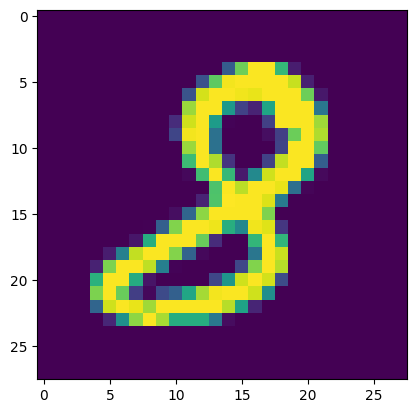

tensor(9, device='cuda:0')


In [12]:
# Get a batch of data
# x, y = next(iter(test_loader))
# x = x.to(device)
# y = y.to(device)

# plt.imshow(x[0].cpu().view(28, 28))
# plt.show()
# print(torch.argmax(net(x[0].view(-1, 784))[0]))

In [13]:
#